In [2]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
mpl.rcParams['legend.framealpha'] = None
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.numpoints'] = 1
import matplotlib.pyplot as plt
import scipy.constants as const
import os.path
import subprocess
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


      two_track_fit  angle_primary_error
1516            1.0                 9.37
343             1.0                 8.99
224             1.0                 8.32
1220            1.0                 7.88
619             1.0                 6.93
      two_track_fit  delta_angle_primary
1055            1.0                76.01
440             1.0                59.87
815             1.0                53.06
360             1.0                47.28
1438            1.0                36.48
      angle_primary_error  targL  delta_energy
1428                 0.20   7.94        223.78
1529                 0.96   6.19        209.22
1515                 0.02   3.80        180.38
354                  0.63   7.24        173.94
282                  0.38   7.29         70.99
538                  0.25   6.11         67.64
494                  0.15   6.70         66.70
1085                 1.36   6.92         60.04
1604                 0.39   8.83         59.29
855                  0.44   6.03      

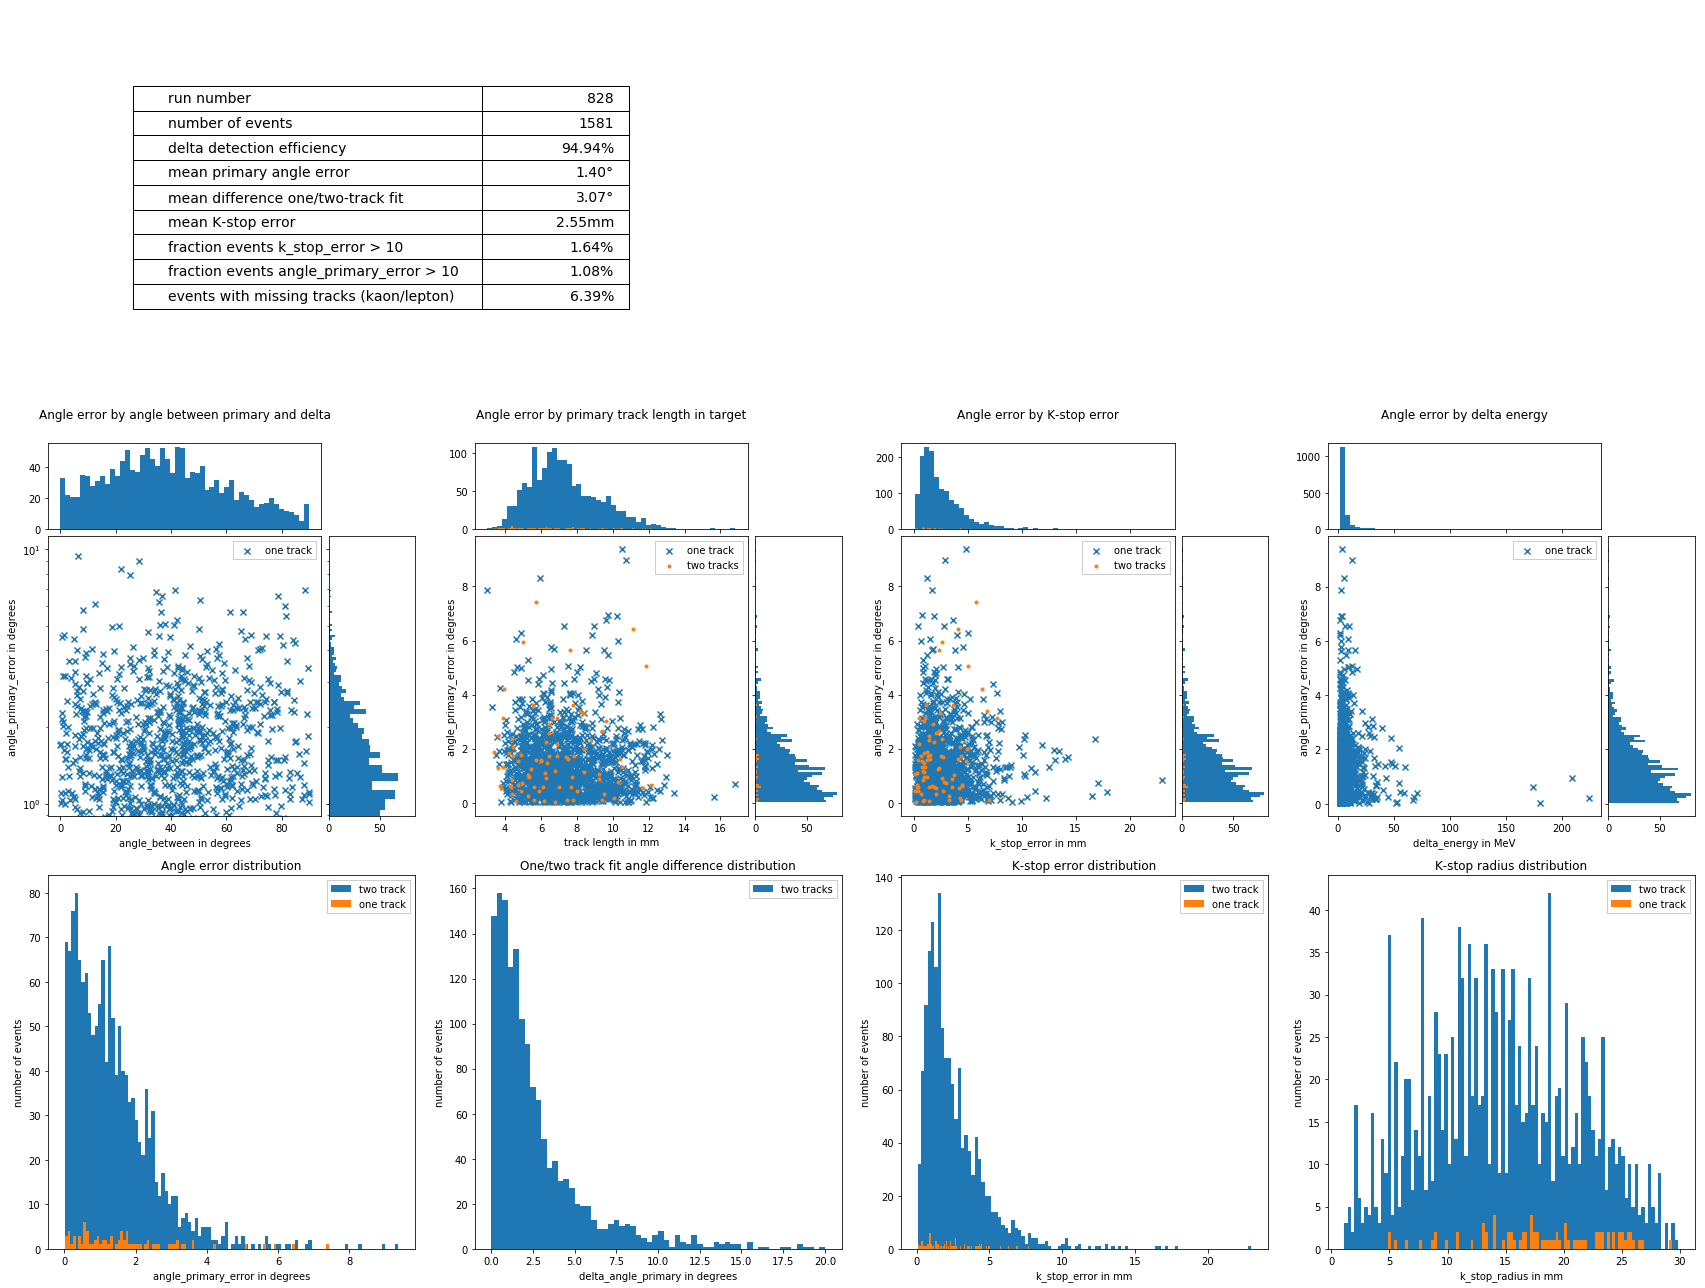

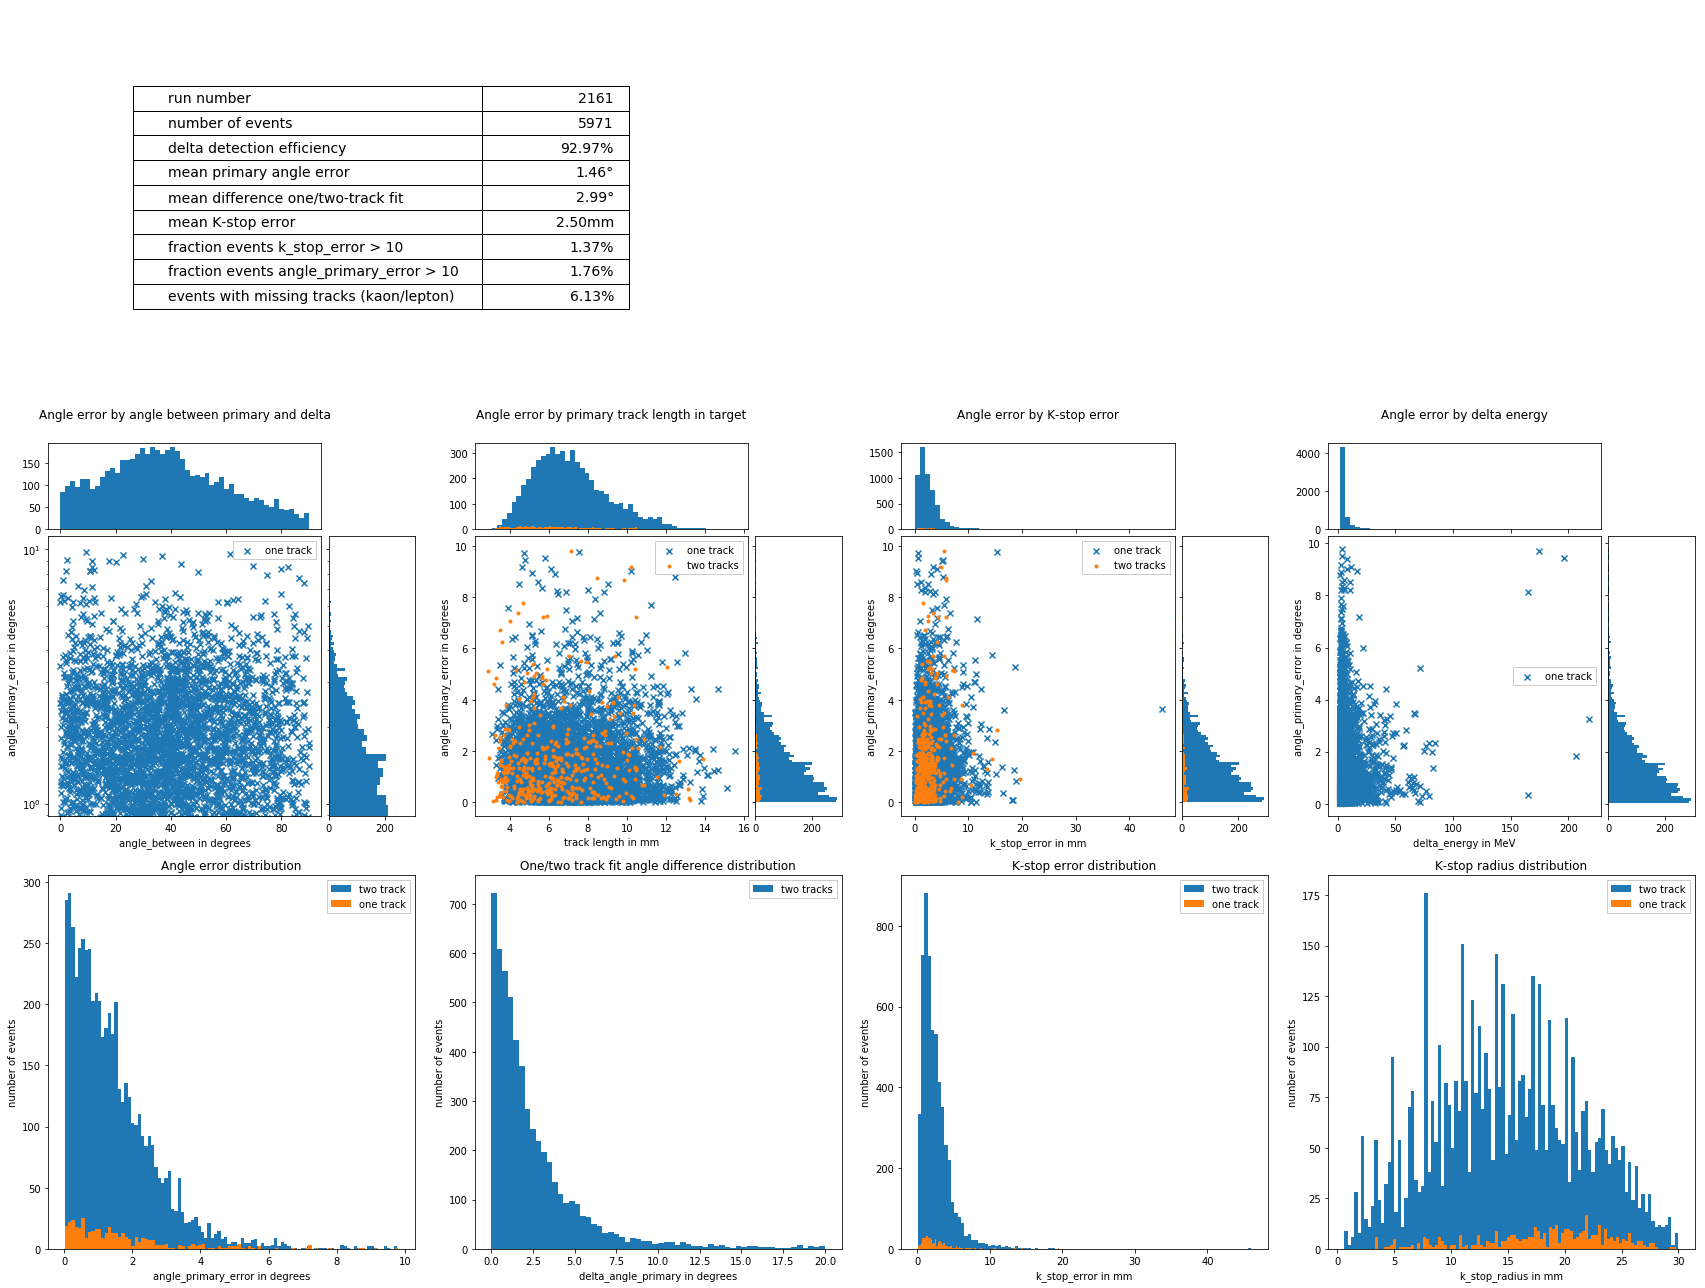

In [79]:
def analyze_run(run_num):
    data_file = 'RUN_{}_Find_Two_Tracks.txt'.format(run_num)
    if not os.path.isfile(data_file):
        cmd = ['root', '-e', '.L Batch_Two_Tracks.C', '-e', 'Batch_Two_Tracks_Fit({}, 0);'.format(run_num)]
        subprocess.Popen(cmd).wait()
        
    data = np.genfromtxt(data_file, delimiter=',')
    frame = pd.DataFrame(data=data, index=data[:,1].astype(int), columns=["Run_Number", "ievt", "reduced_ChiS", "ndf", "first_track_ChiS_reduced", "ndf_2", "second_track_ChiS_reduced", "ndf_3", "E_positron", "delta_energy", "delta_length", "delta_length_xy", "angle_between", "two_track_fit", "angle_primary_sim", "angle_lepton_all" ,"angle_primary", "delta_angle_primary", "angle_secondary", "delta_angle_secondary", "k_stop_error", "angle_primary_error", "targL", "no_leptons", "no_kaons", "k_stop_radius"])
    
    cuts = []
    cut_no_empty_tracks              = ( (frame['no_leptons'] == 0) & (frame['no_kaons'] == 0) )
    frame = frame[cut_no_empty_tracks]
    cut_k_stop_error_gt_10           = (frame['k_stop_error']        > 10)
    cut_angle_primary_error_positive = (frame['angle_primary_error'] > 0)
    cuts.append(cut_angle_primary_error_positive)
    cut_k_stop_error_lt_100          = (frame['k_stop_error']        < 100)
    cuts.append(cut_k_stop_error_lt_100)
    cut_angle_primary_error_lt_10    = (frame['angle_primary_error'] < 10)
    cuts.append(cut_angle_primary_error_lt_10)
    
    with open("problematic-events.txt", 'w') as file:
        file.write(frame[cut_k_stop_error_gt_10].sort_values(by='k_stop_error', ascending=False)['k_stop_error'].to_csv(sep="\t", header=True))
        file.write("\n\n")
        file.write(frame[~cut_angle_primary_error_lt_10].sort_values(by='angle_primary_error', ascending=False)['angle_primary_error'].to_csv(sep="\t", header=True))

    
    for cut in cuts:
        frame = frame[cut]
    
    num_events = len(frame.index)
    delta_detection_efficiency = np.count_nonzero(frame['two_track_fit'] == 1) / num_events

    info = []
    info.append(["run number", "{}".format(int(frame['Run_Number'].mean()))])
    info.append(["number of events", "{}".format(len(frame['ievt']))])
    info.append(["delta detection efficiency", "{:.2f}%".format(delta_detection_efficiency*100)])
    info.append(["mean primary angle error", "{:.2f}°".format(frame['angle_primary_error'].mean())])
    info.append(["mean difference one/two-track fit", "{:.2f}°".format(np.nanmean(frame['delta_angle_primary']))])
    info.append(["mean K-stop error", "{:.2f}mm".format(frame['k_stop_error'].mean())])
    info.append(["fraction events k_stop_error > 10", "{:.2f}%".format(cut_k_stop_error_gt_10.sum()/num_events*100)])
    info.append(["fraction events angle_primary_error > 10", "{:.2f}%".format((~cut_angle_primary_error_lt_10).sum()/num_events*100)])
    info.append(["events with missing tracks (kaon/lepton)", "{:.2f}%".format((~cut_no_empty_tracks).sum()/num_events*100)])
    
    cut_two_track_fit = (frame['two_track_fit'] == 1)
    one_track_frame = frame[~cut_two_track_fit]
    frame = frame[cut_two_track_fit]
    print(frame.sort_values(by='angle_primary_error', ascending=False)[['two_track_fit','angle_primary_error']].head())
    print(frame.sort_values(by='delta_angle_primary', ascending=False)[['two_track_fit','delta_angle_primary']].head())
    print(frame.sort_values(by='delta_energy', ascending=False)[['angle_primary_error', 'targL', 'delta_energy']].head(10))
    
    PLOT_ROWS=3
    PLOT_COLS=4
    PLOT_SIZE=6
    fig = plt.figure(figsize=(PLOT_COLS*PLOT_SIZE, PLOT_ROWS*PLOT_SIZE))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    plt.subplot(PLOT_ROWS, PLOT_COLS, 2)
    plt.axis('off')
    info = np.array(info)
    info_table = plt.table(rowLabels=info[:,0], cellText=info[:,1].reshape(-1,1), colWidths=[0.2], loc='center left')
    info_table.set_fontsize(14)
    info_table.scale(2,1.5)
    
    projection_plot(
        plt.subplot(PLOT_ROWS, PLOT_COLS, PLOT_COLS+1),
        frame, "angle_between", "angle_primary_error", commands=lambda ax: (
        ax.legend(),
        ax.set_yscale("log"),
        ax.set_title("Angle error by angle between primary and delta", y=1.4),
        ax.set_xlabel("angle_between in degrees"),
        ax.set_ylabel("angle_primary_error in degrees")))
    
    projection_plot(
        plt.subplot(PLOT_ROWS, PLOT_COLS, PLOT_COLS+2),
        frame, "targL", "angle_primary_error", one_track_frame, commands=lambda ax: (
        ax.legend(),
        ax.set_title("Angle error by primary track length in target", y=1.4),
        ax.set_xlabel("track length in mm"),
        ax.set_ylabel("angle_primary_error in degrees")))
    
    projection_plot(
        plt.subplot(PLOT_ROWS, PLOT_COLS, PLOT_COLS+3),
        frame, "k_stop_error", "angle_primary_error", one_track_frame, commands=lambda ax: (
        ax.legend(),
#        ax.set_xscale('log'),
#        ax.set_yscale('log'),
        ax.set_title("Angle error by K-stop error", y=1.4),
        ax.set_xlabel("k_stop_error in mm"),
        ax.set_ylabel("angle_primary_error in degrees")))

    projection_plot(
        plt.subplot(PLOT_ROWS, PLOT_COLS, PLOT_COLS+4),
        frame, "delta_energy", "angle_primary_error", commands=lambda ax: (
        ax.legend(),
        ax.set_title("Angle error by delta energy", y=1.4),
        ax.set_xlabel("delta_energy in MeV"),
        ax.set_ylabel("angle_primary_error in degrees")))
    
    plt.subplot(PLOT_ROWS, PLOT_COLS, 2*PLOT_COLS+1)
    plt.title("Angle error distribution")
    plt.xlabel("angle_primary_error in degrees")
    plt.ylabel("number of events")
    plt.hist(frame['angle_primary_error'], bins=100, label="two track")
    plt.hist(one_track_frame['angle_primary_error'], bins=100, label="one track")
    plt.legend()
    # maybe go to two axis with normalized scaling?
    
    plt.subplot(PLOT_ROWS, PLOT_COLS, 2*PLOT_COLS+2)
    plt.title("One/two track fit angle difference distribution")
    plt.xlabel("delta_angle_primary in degrees")
    plt.ylabel("number of events")
    plt.hist(frame['delta_angle_primary'], bins=60, range=(frame['delta_angle_primary'].min(), 20), label="two tracks")
    plt.legend()
    
    plt.subplot(PLOT_ROWS, PLOT_COLS, 2*PLOT_COLS+3)
    plt.title("K-stop error distribution")
    plt.xlabel("k_stop_error in mm")
    plt.ylabel("number of events")
    plt.hist(frame['k_stop_error'], bins=100, label="two track")
    plt.hist(one_track_frame['k_stop_error'], bins=100, label="one track")
    plt.legend()
    
    plt.subplot(PLOT_ROWS, PLOT_COLS, 2*PLOT_COLS+4)
    plt.title("K-stop radius distribution")
    plt.xlabel("k_stop_radius in mm")
    plt.ylabel("number of events")
    plt.hist(frame['k_stop_radius'], bins=100, label="two track")
    plt.hist(one_track_frame['k_stop_radius'], bins=100, label="one track")
    plt.legend()

    plt.tight_layout()
    return fig

def projection_plot(ax, frame, column_x, column_y, frame_one_track=None, commands=None, bins=100):
    #ax.tick_params(top=True, left=True, bottom=True, right=True, labeltop=True, labelleft=True, labelbottom=True, labelright=True)
    ax.scatter(frame[column_x], frame[column_y], label="one track", marker='x')
    
    divider = make_axes_locatable(ax)
    ax_hist_x = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
    for tl in ax_hist_x.get_xticklabels():
        tl.set_visible(False)
    ax_hist_x.hist(frame[column_x], bins=50)
    
    ax_hist_y = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)
    for tl in ax_hist_y.get_yticklabels():
        tl.set_visible(False)
    ax_hist_y.hist(frame[column_y], orientation='horizontal', bins=bins)
    
    if frame_one_track is not None:
        ax.scatter(frame_one_track[column_x], frame_one_track[column_y], label="two tracks", marker='.')
        ax_hist_x.hist(frame_one_track[column_x], bins=bins)
        ax_hist_y.hist(frame_one_track[column_y], orientation='horizontal', bins=bins)
    
    if commands is not None:
        commands(ax)
    
def plot_analysis(runs, filename):
    with PdfPages(filename) as pdf:
        for run in runs:
            fig = analyze_run(run)
            pdf.savefig(fig)
        pdf.infodict()['Title'] = "Two Track Batch Meta Analysis {}".format(runs)        
        
analyze_run(828)

runs = [828,1012,12121,12131]
runs = [2141, 2142]
runs = [2161]
plot_analysis(runs, "two-track-batch-meta_{}.pdf".format(runs))

In [117]:
def test_batch_run_if_needed(runs):
    for run_num in runs:
        data_file = 'RUN_{}_Find_Two_Tracks.txt'.format(run_num)
        if not os.path.isfile(data_file):
            print("{} does not exist, running it".format(run_num))
            cmd = ['root', 'Many_Tracks_Fit_2.2.C', '-e', 'FindTwoTracks({}, 0);'.format(run_num)]
            cmd = ['root', '-e', '.L Batch_Two_Tracks.C', '-e', 'Batch_Two_Tracks_Fit({}, 0);'.format(run_num)]

            #subprocess.Popen(cmd).wait()
            result = subprocess.run(cmd, stdout=subprocess.PIPE)
            print(result)
test_batch_run_if_needed(runs)j

12121 does not exist, running it
CompletedProcess(args=['root', '-e', '.L Batch_Two_Tracks.C', '-e', 'Batch_Two_Tracks_Fit(12121, 0);'], returncode=0, stdout=b"   ------------------------------------------------------------\n  | Welcome to ROOT 6.08/06                http://root.cern.ch |\n  |                               (c) 1995-2016, The ROOT Team |\n  | Built for linuxx8664gcc                                    |\n  | From tag v6-08-06, 2 March 2017                            |\n  | Try '.help', '.demo', '.license', '.credits', '.quit'/'.q' |\n   ------------------------------------------------------------\n\n\n")
12131 does not exist, running it
CompletedProcess(args=['root', '-e', '.L Batch_Two_Tracks.C', '-e', 'Batch_Two_Tracks_Fit(12131, 0);'], returncode=0, stdout=b"   ------------------------------------------------------------\n  | Welcome to ROOT 6.08/06                http://root.cern.ch |\n  |                               (c) 1995-2016, The ROOT Team |\n  | Built for li

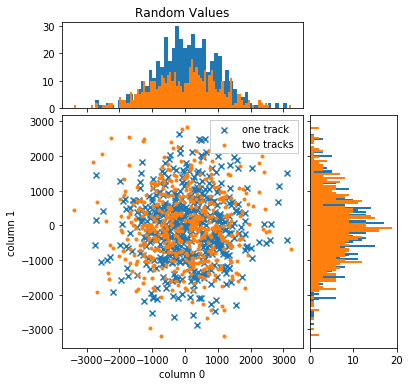

In [73]:
df = pd.DataFrame(np.random.randn(1000, 3)*1000, columns=["a", "b", "c"])
cut = df["c"] < 20
frame1 = df[cut]
frame2 = df[~cut]

plt.figure(figsize=(6,6))
projection_plot(plt.subplot(), frame1, "a", "b", frame2, commands=lambda ax: (
    ax.legend(),
#    ax.set_xscale('log'),
#    ax.set_yscale('log'),
    ax.set_title("Random Values", y=1.4),
    ax.set_xlabel("column 0"),
    ax.set_ylabel("column 1")))